# Import Libraries

In [13]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import ast
import time
import numpy as np
import csv
import boto3 
import pickle
import os
import matplotlib.pyplot as plt
import requests
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import xgboost
from numpy import asarray
from pandas import read_csv
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
% matplotlib inline

UsageError: Line magic function `%` not found.


# Data Processing

In [2]:
df = pd.read_excel(r'BBC_1000_new.xlsx')
df.shape

(1000, 22)

In [3]:
# transform links in column 'SiteLink' to be clickable 
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">{}</a>'.format(val, val)

df.style.format({'SiteLink': make_clickable})

,Unnamed: 0,Likes at Posting,Followers at Posting,Post Created,Post Created Date,Post Created Time,Total Interactions,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,FacebookURL,Message,SiteLink,Link Text,Overperforming Score,ImageCode
0,0,53988518,57589964,2021-11-22 12:05:43 EST,2021-11-22 00:00:00,12:05:43,827,508,235,31,2,13,23,4,6,5,https://www.facebook.com/228735667216/posts/10159144764637217,A private investigator has apologised for targeting the Duke of Sussex's ex-girlfriend Chelsy Davy for surveillance while they were dating.,https://bbc.in/3cyRvI2,Private investigator apologises for targeting Prince Harry's ex-girlfriend,1.050000,0
1,1,53988518,57589964,2021-11-22 11:42:09 EST,2021-11-22 00:00:00,11:42:09,2963,587,1523,146,21,31,45,17,590,3,https://www.facebook.com/228735667216/posts/10159144731632217,"More than 25,000 people have reached the UK by boat via the English Channel this year.",https://bbc.in/3r0i8Oy,Migrants reaching UK three times 2020's total,3.060000,1
2,2,53988518,57589964,2021-11-22 10:18:41 EST,2021-11-22 00:00:00,10:18:41,1524,495,456,179,2,84,21,33,253,1,https://www.facebook.com/228735667216/posts/10159144626862217,"A craze on the social media app has seen children share videos of staff with inappropriate hashtags and comments and, sometimes, superimposing their faces onto pornography.",https://bbc.in/3qZMpwY,TikTok paedophile slurs forcing teachers out,1.300000,2
3,3,53988518,57589964,2021-11-22 09:41:56 EST,2021-11-22 00:00:00,09:41:56,5735,3643,260,154,1340,144,0,1,0,193,https://www.facebook.com/228735667216/posts/10159144588227217,"Max Woosey is still sleeping outside and will embark on a 600th night under canvas in Braunton, Devon.",https://bbc.in/2Zaq8AS,"Tent boy raises £680,000 for hospice",4.580000,3
4,4,53988518,57589964,2021-11-22 09:01:10 EST,2021-11-22 00:00:00,09:01:10,473,301,68,52,3,7,36,3,3,0,https://www.facebook.com/228735667216/posts/10159144530482217,Meta's plans to protect messages on the platforms have been put back until 2023 in a row over child safety.,https://bbc.in/3oOvzOI,Facebook and Instagram encryption plans delayed,-2.900000,4
5,5,53988518,57589964,2021-11-22 07:53:22 EST,2021-11-22 00:00:00,07:53:22,4178,1057,1637,718,9,343,62,297,47,8,https://www.facebook.com/228735667216/posts/10159144460502217,Bulb Energy has 1.7 million customers and is the largest UK gas and electricity company to face difficulties in the wake of a sharp rise in wholesale gas prices.,https://bbc.in/3DJAhU9,Energy firm Bulb set to go into administration,2.820000,5
6,6,53988518,57589964,2021-11-22 07:09:36 EST,2021-11-22 00:00:00,07:09:36,888,487,259,41,7,4,55,20,8,7,https://www.facebook.com/228735667216/posts/10159144413142217,"The Women's Tennis Association said the recent videos ""don't alleviate or address the WTA's concern about her wellbeing and ability to communicate without censorship or coercion"".",https://bbc.in/3oTBWAx,WTA remain concerned for Peng Shuai after IOC call,-1.790000,6
7,7,53988518,57589964,2021-11-22 06:41:41 EST,2021-11-22 00:00:00,06:41:41,1856,780,581,56,18,21,383,3,10,4,https://www.facebook.com/228735667216/posts/10159144384882217,Matt Doran admitted during an interview with Adele that he had not listened to her new album.,https://bbc.in/3nE4bn9,TV host sorry for Adele interview blunder,1.140000,7
8,8,53988518,57589964,2021-11-22 05:26:15 EST,2021-11-22 00:00:00,05:26:15,8887,2336,738,530,21,1708,9,3180,304,61,https://www.facebook.com/228735667216/posts/10159144316397217,"Two mothers who died of herpes after ​having Caesareans could have been infected by a single surgeon, a BBC investigation has found.",https://bbc.in/3DIetbt,Surgeon may have links to infection deaths of mothers,5.050000,8
9,9,53988518,57589964,2021-11-22 04:44:34 EST,2021-11-22 00:00:00,04:44:34,403,301,42,49,2,0,7,0,0,2,https://www.facebook.com/228735667216/posts/10159144277737217,"The tweaks are designed to add additional detail around the existing practices, but nothing about its actual servic

In [4]:
# image pre-processing (delete pictures that have no sense with the analysis and check for duplicates in Link Text column)

df1 = df.head(1000)
list1 = df1['SiteLink'].tolist()

l1 = []
for site in list1:
    response = requests.get(site)
    doc = BeautifulSoup(response.text, 'html.parser')
    headlines = doc.find_all('img')
    l1 += [headlines[0]['src']]

counter = -1
link_name = []
for img in l1:
    
    counter = counter + 1    
    # We can split the file based upon / and extract the last split within the python list below:
    file_name = img.split('/')[-1]
    file_name2 = file_name.split('.')[0]
    file_name2 = "_" + str(counter) + "."
    file_name = file_name2 + file_name.split('.')[-1]
    print(f"This is the file name: {file_name}")
    link_name.append(file_name)
    
    # Now let's send a request to the image URL:
    r = requests.get(img, stream=True)
    
    # We can check that the status code is 200 before doing anything else:
    if r.status_code == 200:
        # This command below will allow us to write the data to a file as binary:
        with open(file_name, 'wb') as f:
            for chunk in r:
                f.write(chunk)
    else:
        # We will write all of the images back to the broken_images list:
        broken_images.append(img)

This is the file name: _0.jpg
This is the file name: _1.jpg
This is the file name: _2.jpg
This is the file name: _3.jpg
This is the file name: _4.jpg
This is the file name: _5.jpg
This is the file name: _6.jpg
This is the file name: _7.jpg
This is the file name: _8.jpg
This is the file name: _9.jpg
This is the file name: _10.jpg
This is the file name: _11.jpg
This is the file name: _12.jpg
This is the file name: _13.jpg
This is the file name: _14.jpg
This is the file name: _15.jpg
This is the file name: _16.png
This is the file name: _17.jpg
This is the file name: _18.jpg
This is the file name: _19.jpg
This is the file name: _20.jpg
This is the file name: _21.jpg
This is the file name: _22.jpg
This is the file name: _23.png
This is the file name: _24.jpg
This is the file name: _25.jpg
This is the file name: _26.jpg
This is the file name: _27.png
This is the file name: _28.jpg
This is the file name: _29.jpg
This is the file name: _30.png
This is the file name: _31.jpg
This is the file n

This is the file name: _260.jpg
This is the file name: _261.jpg
This is the file name: _262.jpg
This is the file name: _263.jpg
This is the file name: _264.jpg
This is the file name: _265.jpg
This is the file name: _266.jpg
This is the file name: _267.jpg
This is the file name: _268.jpg
This is the file name: _269.jpg
This is the file name: _270.jpg
This is the file name: _271.jpg
This is the file name: _272.jpg
This is the file name: _273.jpg
This is the file name: _274.jpg
This is the file name: _275.jpg
This is the file name: _276.jpg
This is the file name: _277.png
This is the file name: _278.jpg
This is the file name: _279.jpg
This is the file name: _280.jpg
This is the file name: _281.jpg
This is the file name: _282.jpg
This is the file name: _283.jpg
This is the file name: _284.jpg
This is the file name: _285.jpg
This is the file name: _286.jpg
This is the file name: _287.jpg
This is the file name: _288.jpg
This is the file name: _289.png
This is the file name: _290.jpg
This is 

This is the file name: _517.jpg
This is the file name: _518.jpg
This is the file name: _519.jpg
This is the file name: _520.jpg
This is the file name: _521.jpg
This is the file name: _522.jpg
This is the file name: _523.jpg
This is the file name: _524.jpg
This is the file name: _525.jpg
This is the file name: _526.jpg
This is the file name: _527.jpg
This is the file name: _528.jpg
This is the file name: _529.jpg
This is the file name: _530.jpg
This is the file name: _531.jpg
This is the file name: _532.jpg
This is the file name: _533.jpg
This is the file name: _534.jpg
This is the file name: _535.png
This is the file name: _536.jpg
This is the file name: _537.jpg
This is the file name: _538.jpg
This is the file name: _539.jpg
This is the file name: _540.jpg
This is the file name: _541.jpg
This is the file name: _542.jpg
This is the file name: _543.jpg
This is the file name: _544.jpg
This is the file name: _545.jpg
This is the file name: _546.jpg
This is the file name: _547.jpg
This is 

This is the file name: _774.jpg
This is the file name: _775.jpg
This is the file name: _776.jpg
This is the file name: _777.jpg
This is the file name: _778.jpg
This is the file name: _779.jpg
This is the file name: _780.jpg
This is the file name: _781.jpg
This is the file name: _782.jpg
This is the file name: _783.jpg
This is the file name: _784.jpg
This is the file name: _785.jpg
This is the file name: _786.jpg
This is the file name: _787.jpg
This is the file name: _788.jpg
This is the file name: _789.jpg
This is the file name: _790.jpg
This is the file name: _791.jpg
This is the file name: _792.jpg
This is the file name: _793.jpg
This is the file name: _794.jpg
This is the file name: _795.png
This is the file name: _796.jpg
This is the file name: _797.jpg
This is the file name: _798.jpg
This is the file name: _799.jpg
This is the file name: _800.jpg
This is the file name: _801.jpg
This is the file name: _802.jpg
This is the file name: _803.jpg
This is the file name: _804.jpg
This is 

In [5]:
# create a photo name description to be joined with the main table
imgurl = pd.DataFrame(l1)
imgurl = imgurl.rename(columns={0: 'Link_Name'})
imgurl.index += 1

imgurl2 = pd.DataFrame(link_name)
imgurl2 = imgurl2.rename(columns={0: 'Photo_Name'})
imgurl2.index += 1

imgurl['Photo_Name'] = imgurl2['Photo_Name']
idx = 0
imgurl.insert(idx, 'ImageCode', value=np.arange(len(imgurl)))

df_final = df.head(1000)
df_final = pd.merge(df_final,imgurl[["ImageCode","Photo_Name"]],on='ImageCode')
df_final

,Unnamed: 0,Likes at Posting,Followers at Posting,Post Created,Post Created Date,Post Created Time,Total Interactions,Likes,Comments,Shares,...,Sad,Angry,Care,FacebookURL,Message,SiteLink,Link Text,Overperforming Score,ImageCode,Photo_Name
0,0,53988518,57589964,2021-11-22 12:05:43 EST,2021-11-22,12:05:43,827,508,235,31,...,4,6,5,https://www.facebook.com/228735667216/posts/10...,A private investigator has apologised for targ...,https://bbc.in/3cyRvI2,Private investigator apologises for targeting ...,1.05,0,_0.jpg
1,1,53988518,57589964,2021-11-22 11:42:09 EST,2021-11-22,11:42:09,2963,587,1523,146,...,17,590,3,https://www.facebook.com/228735667216/posts/10...,"More than 25,000 people have reached the UK by...",https://bbc.in/3r0i8Oy,Migrants reaching UK three times 2020's total,3.06,1,_1.jpg
2,2,53988518,57589964,2021-11-22 10:18:41 EST,2021-11-22,10:18:41,1524,495,456,179,...,33,253,1,https://www.facebook.com/228735667216/posts/10...,A craze on the social media app has seen child...,https://bbc.in/3qZMpwY,TikTok paedophile slurs forcing teachers out,1.30,2,_2.jpg
3,3,53988518,57589964,2021-11-22 09:41:56 EST,2021-11-22,09:41:56,5735,3643,260,154,...,1,0,193,https://www.facebook.com/228735667216/posts/10...,Max Woosey is still sleeping outside and will ...,https://bbc.in/2Zaq8AS,"Tent boy raises £680,000 for hospice",4.58,3,_3.jpg
4,4,53988518,57589964,2021-11-22 09:01:10 EST,2021-11-22,09:01:10,473,301,68,52,...,3,3,0,https://www.facebook.com/228735667216/posts/10...,Meta's plans to protect messages on the platfo...,https://bbc.in/3oOvzOI,Facebook and Instagram encryption plans delayed,-2.90,4,_4.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,53907563,57317301,2021-09-11 04:00:44 EDT,2021-09-11,04:00:44,2866,986,722,137,...,8,28,6,https://www.facebook.com/228735667216/posts/10...,The listings remain eight months after scienti...,https://bbc.in/3BYM0wJ,'Anti-radiation' phone stickers still sold on ...,-1.49,995,_995.jpg
996,996,53907563,57317301,2021-09-11 02:01:58 EDT,2021-09-11,02:01:58,552,277,73,41,...,115,4,33,https://www.facebook.com/228735667216/posts/10...,"""Time keeps on requiring endless patience. We ...",https://bbc.in/2VC36kM,MH17: One father's testimony marked by despair...,-7.72,996,_996.png
997,997,53907563,57317301,2021-09-11 01:01:33 EDT,2021-09-11,01:01:33,2579,1240,220,183,...,408,1,431,https://www.facebook.com/228735667216/posts/10...,"""We take so many days for granted. We always s...",https://bbc.in/3hnOMEa,9/11 anniversary: 'I'll mark mom's death with ...,-1.65,997,_997.jpg
998,998,53907563,57317301,2021-09-11 00:09:37 EDT,2021-09-11,00:09:37,5020,2260,1271,170,...,836,134,15,https://www.facebook.com/228735667216/posts/10...,A manhunt was launched after six inmates tunne...,https://bbc.in/3nr43Yv,Two of six Palestinian prison escapees recaptured,1.18,998,_998.jpg


# AWS Rekognition Object/Scene Detection API

In [50]:
########### Paths
# Path to where your want to save the resulting labels
rekog_results_dir = 'C:/Users/sofia/Desktop/ΔΙΠΛΩΜΑΤΙΚΗ/results/'
# Path to where your images are
rekog_images_dir = 'C:/Users/sofia/Desktop/ΔΙΠΛΩΜΑΤΙΚΗ/data/'

In [51]:
########### Connect to Rekognition API
# Read in your personal keys
personal_access_key = ""
secret_access_key = ""

# Initialize the boto client to access the Rekogniton api
client=boto3.client('rekognition','us-east-1', # or choose the best region for your work, 
                                               # e.g. the location of your S3 bucket if using that method to store images
                    aws_access_key_id = personal_access_key, 
                    aws_secret_access_key = secret_access_key)

In [52]:
########### Create a list of images to run through the API
# Make a list of all the images in the rekog_data_dir you created
local_images = os.listdir(rekog_images_dir)

In [49]:
#local_images[:200]
#local_images[200:400]
#local_images[400:600]
#local_images[600:800]
#local_images[800:1000]

In [61]:
########### Run each image through the API and store the results
##### Detect labels
### Insert 200 pictures each time and change the path of the excel below
holder_labels = []

for imageFile in local_images[800:1000]: # change here each time the number of images to be inserted (200 pictures each time)
    with open(rekog_images_dir + imageFile, 'rb') as image:
            response = client.detect_labels(Image={'Bytes': image.read()})
    
    print('Detected labels for ' + imageFile)
    
    ## If no labels detected, still save the info:
    if len(response['Labels']) == 0:
        print ("No Labels Detected")
        temp_dict = {}
        temp_dict["image_id"] = imageFile
        temp_dict["full_detect_labels_response"] = response
        temp_dict["label_num"] = ''
        temp_dict["label_str"] = ''
        temp_dict["label_conf"] = ''
        holder_labels.append(temp_dict)   
    
    else:
        
        label_counter = 1
        
        for label in response['Labels']:
            print (label['Name'] + ' : ' + str(label['Confidence']))
            temp_dict = {}
            temp_dict["image_id"] = imageFile
            temp_dict["full_detect_labels_response"] = response
            temp_dict["label_num"] = label_counter
            temp_dict["label_str"] = label['Name']
            temp_dict["label_conf"] = label['Confidence']
            label_counter +=1 # update for the next label
            holder_labels.append(temp_dict)
            
len(holder_labels)

Detected labels for _819.jpg
Truck : 99.91127014160156
Transportation : 99.91127014160156
Vehicle : 99.91127014160156
Van : 92.47103881835938
Car : 84.03502655029297
Automobile : 84.03502655029297
Moving Van : 79.7703857421875
Detected labels for _82.jpg
Mobile Phone : 99.98690795898438
Cell Phone : 99.98690795898438
Phone : 99.98690795898438
Electronics : 99.98690795898438
Iphone : 86.24700927734375
Detected labels for _820.jpg
Person : 98.94991302490234
Human : 98.94991302490234
Car : 98.2536392211914
Automobile : 98.2536392211914
Transportation : 98.2536392211914
Vehicle : 98.2536392211914
Nature : 98.2194595336914
Outdoors : 56.1886100769043
Earthquake : 55.771060943603516
Detected labels for _821.jpg
Person : 99.34191131591797
Human : 99.34191131591797
Market : 98.76199340820312
Plant : 95.79180145263672
Shop : 94.18956756591797
Grocery Store : 89.08808898925781
Bazaar : 84.86524963378906
Vegetable : 81.21968078613281
Food : 81.21968078613281
Produce : 74.77473449707031
Cabbage : 

Detected labels for _844.jpg
Person : 99.32147216796875
Human : 99.32147216796875
Glasses : 96.26693725585938
Accessories : 96.26693725585938
Accessory : 96.26693725585938
Art : 94.0182876586914
Hand : 81.08251953125
Drawing : 80.23764038085938
Photography : 69.8411865234375
Photo : 69.8411865234375
Finger : 67.40860748291016
Portrait : 65.06108856201172
Face : 65.06108856201172
Sketch : 63.880611419677734
Painting : 59.91722869873047
Detected labels for _845.png
Face : 99.98497772216797
Person : 99.98497772216797
Human : 99.98497772216797
Glasses : 99.35839080810547
Accessories : 99.35839080810547
Accessory : 99.35839080810547
Beard : 97.30998229980469
Mustache : 73.17652893066406
Tie : 69.09772491455078
Frown : 57.18231964111328
Detected labels for _846.jpg
Person : 97.03755950927734
Human : 97.03755950927734
Clothing : 88.00392150878906
Apparel : 88.00392150878906
Cushion : 83.65128326416016
Finger : 73.03922271728516
Shirt : 62.08547592163086
Chef : 60.35885238647461
Face : 55.4988

Detected labels for _868.jpg
Engine : 99.49142456054688
Machine : 99.49142456054688
Motor : 99.49142456054688
Turbine : 95.25566864013672
Wind Turbine : 92.99581146240234
Cross : 70.96232604980469
Symbol : 70.96232604980469
Detected labels for _869.jpg
Hair : 98.68379974365234
Person : 98.5980453491211
Human : 98.5980453491211
Door : 84.60237121582031
Face : 84.51033782958984
Female : 72.87078857421875
Portrait : 62.416893005371094
Photography : 62.416893005371094
Photo : 62.416893005371094
Woman : 61.538719177246094
Finger : 59.44068908691406
Undershirt : 59.00980758666992
Clothing : 59.00980758666992
Apparel : 59.00980758666992
Detected labels for _87.jpg
Person : 99.30406951904297
Human : 99.30406951904297
Crowd : 98.21350860595703
Clothing : 97.57940673828125
Apparel : 97.57940673828125
Parade : 93.63147735595703
People : 79.9113998413086
Plant : 79.4836654663086
Festival : 77.78041076660156
Face : 77.39241790771484
Flower : 69.9725341796875
Blossom : 69.9725341796875
Portrait : 61

Detected labels for _886.jpg
Person : 99.80878448486328
Human : 99.80878448486328
Audience : 99.50216674804688
Crowd : 99.50216674804688
Tie : 96.3378677368164
Accessories : 96.3378677368164
Accessory : 96.3378677368164
People : 81.80944061279297
Suit : 78.26309967041016
Clothing : 78.26309967041016
Coat : 78.26309967041016
Overcoat : 78.26309967041016
Apparel : 78.26309967041016
Speech : 76.10945129394531
Sitting : 72.4060287475586
Lecture : 63.191253662109375
Dating : 58.91337203979492
Video Gaming : 58.44637680053711
Room : 57.10954284667969
Indoors : 57.10954284667969
Female : 56.32146072387695
Detected labels for _887.jpg
Shorts : 99.91205596923828
Clothing : 99.91205596923828
Apparel : 99.91205596923828
Person : 98.84137725830078
Human : 98.84137725830078
Female : 97.9280776977539
Woman : 87.60254669189453
Face : 81.46480560302734
Skirt : 78.90935516357422
Girl : 69.78194427490234
Smile : 59.8586540222168
People : 55.764225006103516
Shoe : 55.31000518798828
Footwear : 55.31000518

Detected labels for _902.png
White : 79.74824523925781
Texture : 79.74824523925781
Gray : 69.33610534667969
Detected labels for _903.jpg
Person : 99.866943359375
Human : 99.866943359375
Nuclear : 89.67572021484375
Rocket : 87.00856018066406
Vehicle : 87.00856018066406
Transportation : 87.00856018066406
Monitor : 71.04597473144531
Electronics : 71.04597473144531
Screen : 71.04597473144531
Display : 71.04597473144531
Missile : 58.84331512451172
Detected labels for _904.jpg
Person : 99.12788391113281
Human : 99.12788391113281
Plant : 96.24349975585938
Flower : 93.1932144165039
Blossom : 93.1932144165039
Flower Bouquet : 92.35533905029297
Flower Arrangement : 92.35533905029297
Photography : 63.28644561767578
Photo : 63.28644561767578
Clothing : 55.732887268066406
Apparel : 55.732887268066406
Detected labels for _905.jpg
Car : 99.68688201904297
Automobile : 99.68688201904297
Transportation : 99.68688201904297
Vehicle : 99.68688201904297
Bird : 83.11797332763672
Animal : 83.11797332763672
Co

Detected labels for _92.jpg
Person : 98.84833526611328
Human : 98.84833526611328
Bread : 93.88570404052734
Food : 93.88570404052734
Sweets : 88.58931732177734
Confectionery : 88.58931732177734
Burger : 76.162353515625
Helmet : 71.96907043457031
Clothing : 71.96907043457031
Apparel : 71.96907043457031
Bun : 61.417396545410156
Pottery : 56.69042205810547
Pita : 55.673828125
Detected labels for _920.jpg
Cow : 98.7394790649414
Mammal : 98.7394790649414
Animal : 98.7394790649414
Cattle : 98.7394790649414
Dog : 67.6876449584961
Canine : 67.6876449584961
Pet : 67.6876449584961
Goat : 62.94017791748047
Detected labels for _921.jpg
Head : 99.98919677734375
Skin : 99.70501708984375
Face : 99.667724609375
Person : 99.667724609375
Human : 99.667724609375
Glasses : 90.6951904296875
Accessories : 90.6951904296875
Accessory : 90.6951904296875
Portrait : 82.31997680664062
Photography : 82.31997680664062
Photo : 82.31997680664062
Man : 81.59581756591797
Label : 76.72116088867188
Text : 76.7211608886718

Detected labels for _940.jpg
Office Building : 82.29850006103516
Building : 82.29850006103516
Outdoors : 81.00011444091797
Car : 78.61365509033203
Automobile : 78.61365509033203
Vehicle : 78.61365509033203
Transportation : 78.61365509033203
Nature : 76.26475524902344
Construction Crane : 70.01324462890625
Construction : 69.5108871459961
Detected labels for _941.jpg
Person : 98.90145874023438
Human : 98.90145874023438
Statue : 98.77271270751953
Sculpture : 98.77271270751953
Art : 98.77271270751953
Monument : 95.97380828857422
Head : 71.77574920654297
Sphere : 63.30033874511719
Bronze : 58.710819244384766
Detected labels for _942.jpg
Sphere : 98.53173828125
Astronomy : 97.2459487915039
Outer Space : 97.1432113647461
Space : 97.1432113647461
Universe : 97.1432113647461
Planet : 95.61311340332031
Globe : 86.11792755126953
Nature : 84.01660919189453
Earth : 78.94328308105469
Outdoors : 74.61425018310547
Bear : 61.47905349731445
Animal : 61.47905349731445
Mammal : 61.47905349731445
Wildlife 

Detected labels for _961.jpg
Person : 99.04988098144531
Human : 99.04988098144531
Clothing : 98.74920654296875
Apparel : 98.74920654296875
Shorts : 96.39747619628906
Rock : 95.91781616210938
Outdoors : 91.26962280273438
Nature : 86.13531494140625
Coat : 77.9863510131836
Ground : 71.63753509521484
Grass : 70.8584976196289
Plant : 70.8584976196289
Jacket : 70.22953033447266
Standing : 58.6505241394043
Water : 57.75545120239258
Land : 57.73896789550781
Path : 56.65275573730469
Sky : 56.262203216552734
Detected labels for _962.jpg
Nature : 99.37421417236328
Outdoors : 99.1674575805664
Mountain : 99.02558898925781
Mountain Range : 96.45072937011719
Plant : 96.16199493408203
Tree : 93.19725799560547
Fir : 86.61540985107422
Abies : 86.61540985107422
Land : 86.21408081054688
Peak : 85.40447998046875
Wilderness : 81.6937255859375
Ground : 76.21318054199219
Plateau : 61.18006134033203
Detected labels for _963.jpg
Transportation : 96.18508911132812
Vehicle : 96.01195526123047
Bonfire : 95.7720794

Detected labels for _98.jpg
Elephant : 99.84527587890625
Mammal : 99.84527587890625
Animal : 99.84527587890625
Wildlife : 99.84527587890625
Detected labels for _980.jpg
Zebra : 99.79932403564453
Mammal : 99.79932403564453
Animal : 99.79932403564453
Wildlife : 99.79932403564453
Detected labels for _981.jpg
Nature : 99.69929504394531
Person : 99.31953430175781
Human : 99.31953430175781
Earthquake : 89.73998260498047
Car : 85.45612335205078
Automobile : 85.45612335205078
Vehicle : 85.45612335205078
Transportation : 85.45612335205078
Urban : 66.15445709228516
Building : 57.61357498168945
Flood : 55.93881607055664
Detected labels for _982.jpg
Person : 97.82056427001953
Human : 97.82056427001953
Clothing : 80.4717788696289
Apparel : 80.4717788696289
Dentist : 75.2905044555664
Doctor : 66.57219696044922
Clinic : 57.60530471801758
Detected labels for _983.jpg
Attorney : 99.98757934570312
Person : 99.98757934570312
Human : 99.98757934570312
Head : 99.83404541015625
Executive : 92.66970825195312

Detected labels for _999.png
School : 99.43144226074219
Person : 99.3558349609375
Human : 99.3558349609375
Classroom : 98.54410552978516
Room : 98.54410552978516
Indoors : 98.54410552978516
Chair : 89.60933685302734
Furniture : 89.60933685302734
Coat : 56.7330322265625
Clothing : 56.7330322265625
Apparel : 56.7330322265625


2549

In [62]:
# Write out the results to a csv
with open(rekog_results_dir + 'awsrekognition_detect_labels_5.csv', 'w', newline = '') as csvfile:
    fieldnames = ['image_id', 'full_detect_labels_response',
                  'label_num', 'label_str',
                  'label_conf'
                  ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader() 
    for entry in holder_labels:
        writer.writerow(entry)

In [6]:
# Create the final dataframe
detect_labels_df1 = pd.read_csv('C:/Users/sofia/Desktop/ΔΙΠΛΩΜΑΤΙΚΗ/results/awsrekognition_detect_labels_1.csv')
detect_labels_df2 = pd.read_csv('C:/Users/sofia/Desktop/ΔΙΠΛΩΜΑΤΙΚΗ/results/awsrekognition_detect_labels_2.csv')
detect_labels_df3 = pd.read_csv('C:/Users/sofia/Desktop/ΔΙΠΛΩΜΑΤΙΚΗ/results/awsrekognition_detect_labels_3.csv')
detect_labels_df4 = pd.read_csv('C:/Users/sofia/Desktop/ΔΙΠΛΩΜΑΤΙΚΗ/results/awsrekognition_detect_labels_4.csv')
detect_labels_df5 = pd.read_csv('C:/Users/sofia/Desktop/ΔΙΠΛΩΜΑΤΙΚΗ/results/awsrekognition_detect_labels_5.csv')
detect_labels_df = pd.concat([detect_labels_df1, detect_labels_df2, detect_labels_df3, detect_labels_df4, detect_labels_df5], ignore_index=True)

df_final.rename(columns = {'Photo_Name':'image_id'}, inplace = True)
df_final = pd.merge(df_final,detect_labels_df,on='image_id',how='right')
df_final.to_excel(r'BBC_final_df.xlsx')
df_final

,Unnamed: 0,Likes at Posting,Followers at Posting,Post Created,Post Created Date,Post Created Time,Total Interactions,Likes,Comments,Shares,...,Message,SiteLink,Link Text,Overperforming Score,ImageCode,image_id,full_detect_labels_response,label_num,label_str,label_conf
0,0,53988518,57589964,2021-11-22 12:05:43 EST,2021-11-22,12:05:43,827,508,235,31,...,A private investigator has apologised for targ...,https://bbc.in/3cyRvI2,Private investigator apologises for targeting ...,1.05,0,_0.jpg,"{'Labels': [{'Name': 'Person', 'Confidence': 9...",1,Person,99.832466
1,0,53988518,57589964,2021-11-22 12:05:43 EST,2021-11-22,12:05:43,827,508,235,31,...,A private investigator has apologised for targ...,https://bbc.in/3cyRvI2,Private investigator apologises for targeting ...,1.05,0,_0.jpg,"{'Labels': [{'Name': 'Person', 'Confidence': 9...",2,Human,99.832466
2,0,53988518,57589964,2021-11-22 12:05:43 EST,2021-11-22,12:05:43,827,508,235,31,...,A private investigator has apologised for targ...,https://bbc.in/3cyRvI2,Private investigator apologises for targeting ...,1.05,0,_0.jpg,"{'Labels': [{'Name': 'Person', 'Confidence': 9...",3,Military,99.502411
3,0,53988518,57589964,2021-11-22 12:05:43 EST,2021-11-22,12:05:43,827,508,235,31,...,A private investigator has apologised for targ...,https://bbc.in/3cyRvI2,Private investigator apologises for targeting ...,1.05,0,_0.jpg,"{'Labels': [{'Name': 'Person', 'Confidence': 9...",4,Military Uniform,99.202812
4,0,53988518,57589964,2021-11-22 12:05:43 EST,2021-11-22,12:05:43,827,508,235,31,...,A private investigator has apologised for targ...,https://bbc.in/3cyRvI2,Private investigator apologises for targeting ...,1.05,0,_0.jpg,"{'Labels': [{'Name': 'Person', 'Confidence': 9...",5,Hat,96.088440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13486,999,53907563,57317301,2021-09-10 23:02:08 EDT,2021-09-10,23:02:08,1190,514,408,73,...,Women's education and independent media have b...,https://bbc.in/3E7t1C3,What has changed in Afghanistan in 20 years,-3.58,999,_999.png,"{'Labels': [{'Name': 'School', 'Confidence': 9...",7,Chair,89.609337
13487,999,53907563,57317301,2021-09-10 23:02:08 EDT,2021-09-10,23:02:08,1190,514,408,73,...,Women's education and independent media have b...,https://bbc.in/3E7t1C3,What has changed in Afghanistan in 20 years,-3.58,999,_999.png,"{'Labels': [{'Name': 'School', 'Confidence': 9...",8,Furniture,89.609337
13488,999,53907563,57317301,2021-09-10 23:02:08 EDT,2021-09-10,23:02:08,1190,514,408,73,...,Women's education and independent media have b...,https://bbc.in/3E7t1C3,What has changed in Afghanistan in 20 years,-3.58,999,_999.png,"{'Labels': [{'Name': 'School', 'Confidence': 9...",9,Coat,56.733032
13489,999,53907563,57317301,2021-09-10 23:02:08 EDT,2021-09-10,23:02:08,1190,514,408,73,...,Women's education and independent media have b...,https://bbc.in/3E7t1C3,What has changed in Afghanistan in 20 years,-3.58,999,_999.png,"{'Labels': [{'Name': 'School', 'Confidence': 9...",10,Clothing,56.733032


# Modelling

### Data Pre-processing

In [33]:
df = pd.read_excel(r'BBC_1000_new_v2.xlsx')

In [34]:
df['Post_Created_Hour'] = df['Post Created Time'].str[:2]
df['Post_Created_Hour']=pd.to_numeric(df.Post_Created_Hour)
df['Link_Text_Count'] = df['Link Text'].str.len()

In [35]:
# remove outliers
df.drop(df[df.Likes > 40000].index, inplace=True)

In [36]:
# remove variables not important for our analysis in this step
df.drop(['Post Created', 'Post Created Date', 'Post Created Time', 'FacebookURL', 'Message', 'SiteLink', 'Link Text', 'ImageCode'], axis=1, inplace=True)
# arrange columns
data = df[['Likes', 'Likes at Posting', 'Followers at Posting', 'Total Interactions', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Post_Created_Hour', 'Link_Text_Count', 'Animal', 'Clothing', 'Military', 'Nature', 'Person', 'Vehicle', 'Other', 'Overperforming Score ']]

In [37]:
print("Number of missing values inside the dataset: ", data.isna().sum().sum())

Number of missing values inside the dataset:  0


In [38]:
data['Likes'].describe()

count      993.000000
mean      3454.074522
std       4772.792042
min         88.000000
25%        630.000000
50%       1738.000000
75%       4045.000000
max      36806.000000
Name: Likes, dtype: float64

In [39]:
data.describe()

,Likes,Likes at Posting,Followers at Posting,Total Interactions,Comments,Shares,Love,Wow,Haha,Sad,...,Post_Created_Hour,Link_Text_Count,Animal,Clothing,Military,Nature,Person,Vehicle,Other,Overperforming Score
count,993.000000,9.930000e+02,9.930000e+02,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,...,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000
mean,3454.074522,5.394783e+07,5.747822e+07,7584.837865,1278.907351,492.826788,296.488419,266.642497,651.759315,668.206445,...,10.853978,52.338369,0.085599,0.521652,0.071501,0.135952,0.786506,0.157100,0.732125,-0.226244
std,4772.792042,3.743460e+04,1.090102e+05,9977.856949,1922.941731,819.107268,849.115854,630.110978,2490.205467,2039.922848,...,6.759240,9.482173,0.279912,0.499783,0.257789,0.342910,0.409980,0.364078,0.443075,4.378920
min,88.000000,5.390652e+07,5.731730e+07,160.000000,26.000000,14.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-26.040000
25%,630.000000,5.390828e+07,5.736916e+07,1471.000000,250.000000,85.000000,10.000000,16.000000,20.000000,7.000000,...,5.000000,47.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-2.840000
50%,1738.000000,5.398210e+07,5.757825e+07,3674.000000,600.000000,204.000000,31.000000,57.000000,87.000000,37.000000,...,10.000000,51.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.150000
75%,4045.000000,5.398333e+07,5.758056e+07,9687.000000,1555.000000,524.000000,146.000000,200.000000,315.000000,277.000000,...,17.000000,57.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.430000
max,36806.000000,5.398852e+07,5.758996e+07,116250.000000,21298.000000,9792.000000,10286.000000,6197.000000,53303.000000,23272.000000,...,23.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.460000


array([[<AxesSubplot:title={'center':'Likes'}>,
        <AxesSubplot:title={'center':'Likes at Posting'}>,
        <AxesSubplot:title={'center':'Followers at Posting'}>,
        <AxesSubplot:title={'center':'Total Interactions'}>,
        <AxesSubplot:title={'center':'Comments'}>],
       [<AxesSubplot:title={'center':'Shares'}>,
        <AxesSubplot:title={'center':'Love'}>,
        <AxesSubplot:title={'center':'Wow'}>,
        <AxesSubplot:title={'center':'Haha'}>,
        <AxesSubplot:title={'center':'Sad'}>],
       [<AxesSubplot:title={'center':'Angry'}>,
        <AxesSubplot:title={'center':'Care'}>,
        <AxesSubplot:title={'center':'Post_Created_Hour'}>,
        <AxesSubplot:title={'center':'Link_Text_Count'}>,
        <AxesSubplot:title={'center':'Animal'}>],
       [<AxesSubplot:title={'center':'Clothing'}>,
        <AxesSubplot:title={'center':'Military'}>,
        <AxesSubplot:title={'center':'Nature'}>,
        <AxesSubplot:title={'center':'Person'}>,
        <AxesSubpl

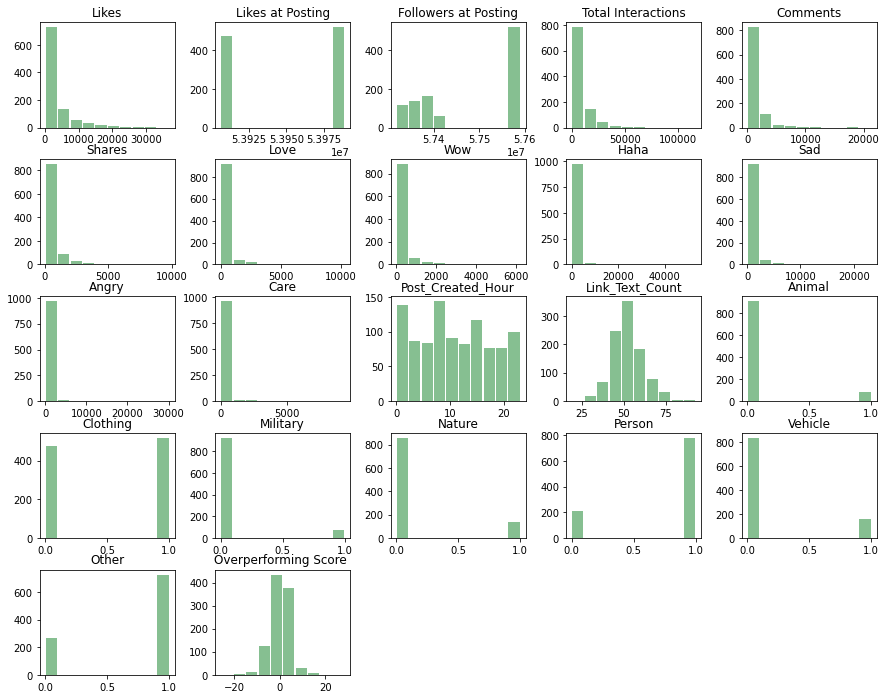

In [40]:
data.hist(grid=False, figsize=(15,12), color='#86bf91', zorder=2, rwidth=0.9)

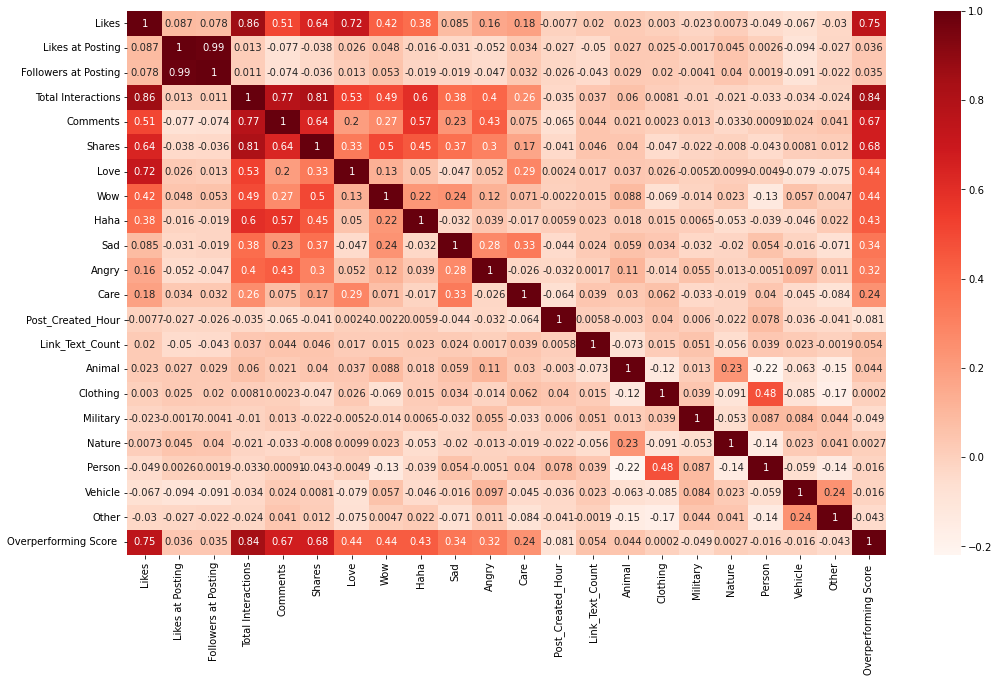

In [41]:
#Using Pearson Correlation
import seaborn as sns
plt.figure(figsize=(17,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [42]:
#Correlation with output variable
# Remove variables correlated with Y and between them > 80% (Remove Total Interactions, Love, Followers at Posting)
cor_target = abs(cor["Likes"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.7]
relevant_features

Likes                    1.000000
Total Interactions       0.861665
Love                     0.718666
Overperforming Score     0.748771
Name: Likes, dtype: float64

In [43]:
# remove variables not important for our analysis and variables correlated > 0.7 with the target variable
data.drop(['Likes at Posting', 'Followers at Posting', 'Total Interactions', 'Comments', 'Shares', 'Love', 'Overperforming Score '], axis=1, inplace=True)
data

C:\Users\konto\Anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Likes,Wow,Haha,Sad,Angry,Care,Post_Created_Hour,Link_Text_Count,Animal,Clothing,Military,Nature,Person,Vehicle,Other
0,508,13,23,4,6,5,12,74,0,1,1,0,1,0,0
1,587,31,45,17,590,3,11,45,0,1,0,0,1,1,1
2,495,84,21,33,253,1,10,44,0,0,0,0,1,0,1
3,3643,144,0,1,0,193,9,36,1,1,0,1,1,0,0
4,301,7,36,3,3,0,9,47,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,986,29,942,8,28,6,4,52,0,0,0,0,0,0,1
996,277,0,2,115,4,33,2,61,0,0,0,0,1,0,1
997,1240,2,17,408,1,431,1,66,0,1,0,0,1,0,1
998,2260,67,124,836,134,15,0,49,0,1,1,0,1,0,1


### 1st Modeling Part - Regression Analysis

Our purpose is to predict the number of likes of a Facebook post, based on the number of attributes that we have previously observed and the different number of extra features we created after the Image Rekognition implementation using the Clarifai portal. To do that we will use a number of different Regression models, which can be used to predict numerical values, not just classes, in order to rectify which one of these yields the best results for our approach. The steps that we followed were:
 * **`Step_1:`** Split the data into training and test sets
 * **`Step_2:`** Train a number of different regression models (Linear, Random Forest, Decision Tree, SVM, XGBoost)
 * **`Step_3:`** Fit the different regression models to the training data
 * **`Step_4:`** Make the necessary predictions
 * **`Step_5:`** Use Grid Search, an Evaluator for our initial predictions and Cross Validation in order to improve our model and find the best model
 * **`Step_6:`** Calculate a number of different metrics (R2, MAE, MSE, RMSE) on test data and print a table showing the basic statistics of the target variable, in order to see if the predictions were worthwhile or not

#### Split dataset into Train/Test sets

In [52]:
from sklearn.model_selection import train_test_split

X = data.drop('Likes', axis=1)
Y = pd.DataFrame(data.Likes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
# X_train (70% from all features without the target variable)
# Y_train (70% including only the target variable)
# X_test (30% from all features without the target variable)
# Y_test (30% including only the target variable -> the numbers that we want to see how much close we are)

#### Perform Cross Validation/Grid Search for all models

In [80]:
# The user can choose one of the below models
a = LinearRegression()
b = RandomForestRegressor(n_estimators = 100, random_state = 0)
c = DecisionTreeRegressor(max_depth=2)

model = b

C:\Users\konto\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed wh

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed wh

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\feature_selection\_rfe.py:310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X[:, features], y, **fit_params)


Coefficients: [0.13066199 0.22781847 0.13464173 0.0571691  0.37385258 0.02591333
 0.02774065 0.00148399 0.0053969  0.0013157  0.002615   0.00626535
 0.00194478 0.00318044]
Mean Absolute Error (MAE) Test: 1446.7077516778525
Mean Absolute Error (MAE) Train: 579.3584748201439
Mean Squared Error (MSE) Test: 7429225.01890235
Mean Squared Error (MSE) Train: 1224903.83692
Root Mean Squared Error (RMSE) Test: 2725.660473885614
Root Mean Squared Error (RMSE) Train: 1106.75373815497
Coefficient of determination (R^2) Test: 0.62
Coefficient of determination (R^2) Train: 0.95


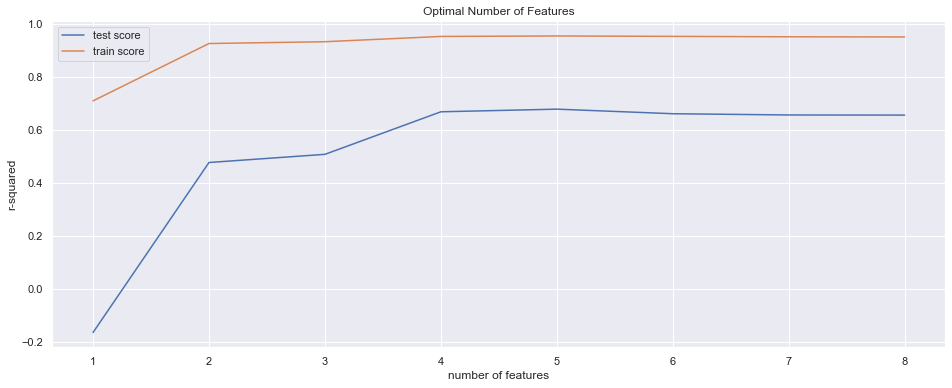

In [81]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 9))}]

# step-3: perform grid search and specify model
model.fit(X_train, Y_train)
rfe = RFE(model)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, Y_train)  

# cross-validation results
cv_results = pd.DataFrame(model_cv.cv_results_)

# final model (FIX THE n_features_optimal FOR EACH MODEL)
n_features_optimal = 8
model.fit(X_train, Y_train)
rfe = RFE(model, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, Y_train)

# predict prices of X_test/X_train
Y_pred_test = model.predict(X_test)
Y_pred_train = model.predict(X_train)

# metrics results (na deiksw poia features exoun to antistoixo coeff)
try:
    print('Coefficients:', model.coef_)
    #print('Intercept:', model.intercept_)
    print('Mean absolute error (MAE) Test: %.2f'
          % mean_absolute_error(Y_test, Y_pred_test, sample_weight=None, multioutput='uniform_average')) 
    print('Mean absolute error (MAE) Train: %.2f'
          % mean_absolute_error(Y_train, Y_pred_train, sample_weight=None, multioutput='uniform_average')) 
    print('Mean squared error (MSE) Test: %.2f'
          % mean_squared_error(Y_test, Y_pred_test)) 
    print('Mean squared error (MSE) Train: %.2f'
          % mean_squared_error(Y_train, Y_pred_train)) 
    print('Root mean squared error (RMSE) Test: %.2f'
          % mean_squared_error(Y_test, Y_pred_test, squared=False)) 
    print('Root mean squared error (RMSE) Train: %.2f'
          % mean_squared_error(Y_train, Y_pred_train, squared=False))
    print('Coefficient of determination (R^2) Test: %.2f'
          % r2_score(Y_test, Y_pred_test))
    print('Coefficient of determination (R^2) Train: %.2f'
          % r2_score(Y_train, Y_pred_train))
except:
    print('Coefficients:', model.feature_importances_)
    #print('Intercept:', model.intercept_)
    print('Mean Absolute Error (MAE) Test:', metrics.mean_absolute_error(Y_test, Y_pred_test))
    print('Mean Absolute Error (MAE) Train:', metrics.mean_absolute_error(Y_train, Y_pred_train))
    print('Mean Squared Error (MSE) Test:', metrics.mean_squared_error(Y_test, Y_pred_test))  
    print('Mean Squared Error (MSE) Train:', metrics.mean_squared_error(Y_train, Y_pred_train))  
    print('Root Mean Squared Error (RMSE) Test:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test)))
    print('Root Mean Squared Error (RMSE) Train:', np.sqrt(metrics.mean_squared_error(Y_train, Y_pred_train)))
    print('Coefficient of determination (R^2) Test: %.2f' % r2_score(Y_test, Y_pred_test))
    print('Coefficient of determination (R^2) Train: %.2f' % r2_score(Y_train, Y_pred_train))
    

# plotting cv results
plt.figure(figsize=(16,6))
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')


In [74]:
actual_df = Y_test
actual_df = actual_df.rename(columns={"Likes": "Actual Likes"})
actual_df = actual_df.reset_index(drop=True)
predicted_df = pd.DataFrame(Y_pred_test)
predicted_df = predicted_df.rename(columns={0: "Predicted Likes"})

actual_predicted_df = pd.concat([actual_df, predicted_df], axis=1)

# Comment each time the model that is not used:
# linear_regression_df = actual_predicted_df
# linear_regression_df['Model'] = 'Linear Regression'
# rf_regression_df = actual_predicted_df
# rf_regression_df['Model'] = 'Random Forest Regression'
# dt_regression_df = actual_predicted_df
# dt_regression_df['Model'] = 'Decision Tree Regression'

#### XGBoost Regression

In [75]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model.fit(X_train, Y_train)

Y_pred_test = model.predict(X_test)

In [76]:
# Evaluating the Algorithm
from sklearn import metrics
print('Coefficients:', model.feature_importances_)
print('Mean Absolute Error (MAE) Test:', metrics.mean_absolute_error(Y_test, Y_pred_test))  
print('Mean Absolute Error (MAE) Train:', metrics.mean_absolute_error(Y_train, Y_pred_train)) 
print('Mean Squared Error (MSE) Test:', metrics.mean_squared_error(Y_test, Y_pred_test))  
print('Mean Absolute Error (MSE) Train:', metrics.mean_squared_error(Y_train, Y_pred_train)) 
print('Root Mean Squared Error (RMSE) Test:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred_test)))
print('Root Mean Squared Error (RMSE) Train:', np.sqrt(metrics.mean_squared_error(Y_train, Y_pred_train)))
print('Coefficient of determination (R^2) Test: %.2f' % r2_score(Y_test, Y_pred_test))
print('Coefficient of determination (R^2) Train: %.2f' % r2_score(Y_train, Y_pred_train))

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Coefficients: [0.07861766 0.11532434 0.10097495 0.05936753 0.31292394 0.04123593
 0.03336007 0.05470124 0.01843879 0.03968011 0.00734888 0.10227768
 0.01663395 0.01911492]
Mean Absolute Error (MAE) Test: 1640.2154904435945
Mean Absolute Error (MAE) Train: 2177.4481759507785
Mean Squared Error (MSE) Test: 9077370.386013357
Mean Absolute Error (MSE) Train: 14911949.148569606
Root Mean Squared Error (RMSE) Test: 3012.8674690423004
Root Mean Squared Error (RMSE) Train: 3861.599299327884
Coefficient of determination (R^2) Test: 0.54
Coefficient of determination (R^2) Train: 0.38
Mean MAE: 1542.211 (265.450)


In [77]:
actual_df = Y_test
actual_df = actual_df.rename(columns={"Likes": "Actual Likes"})
actual_df = actual_df.reset_index(drop=True)
predicted_df = pd.DataFrame(Y_pred_test)
predicted_df = predicted_df.rename(columns={0: "Predicted Likes"})

actual_predicted_df = pd.concat([actual_df, predicted_df], axis=1)
xgb_regression_df = actual_predicted_df
xgb_regression_df['Model'] = 'XGBoost Regression'

#### Final Results

<AxesSubplot:xlabel='Model', ylabel='Actual_Predicted_Differences'>

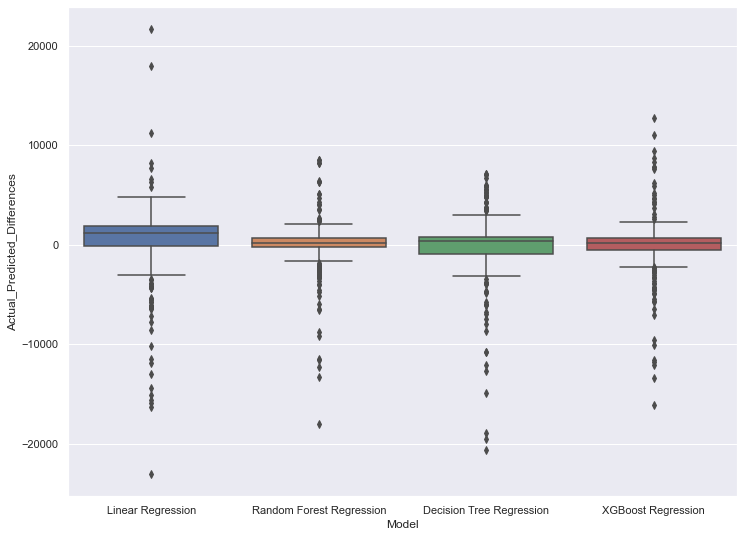

In [78]:
# Make a box plot from the value ranges (predicted/actual) from all the models (Y_pred - Y_test)

dfs = [linear_regression_df, rf_regression_df, dt_regression_df, xgb_regression_df]
actual_predicted_df2 = pd.concat(dfs)
actual_predicted_df2 = actual_predicted_df2.reset_index(drop=True)
actual_predicted_df2["Actual_Predicted_Differences"] = actual_predicted_df2["Predicted Likes"] - actual_predicted_df2["Actual Likes"]


sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,9)})
sns.boxplot(x = 'Model', y = 'Actual_Predicted_Differences', data = actual_predicted_df2)

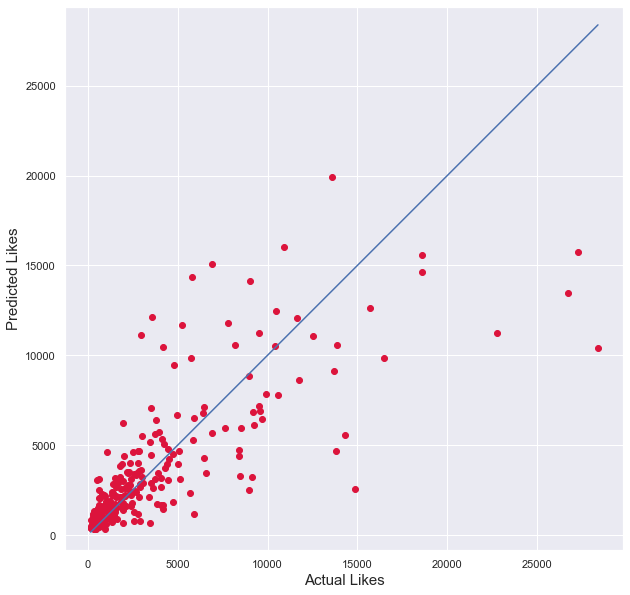

In [79]:
# Make a graph with the predicted vs actual values of the best model
rf_regression_df2 = rf_regression_df.rename(columns={"Predicted Likes": "Predicted_Likes", "Actual Likes": "Actual_Likes"})
Actual_Likes = rf_regression_df2["Actual_Likes"]
Predicted_Likes = rf_regression_df2["Predicted_Likes"]
plt.figure(figsize=(10,10))
plt.scatter(Actual_Likes, Predicted_Likes, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(Predicted_Likes), max(Actual_Likes))
p2 = min(min(Predicted_Likes), min(Actual_Likes))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Likes', fontsize=15)
plt.ylabel('Predicted Likes', fontsize=15)
plt.axis('equal')
plt.show()

### 2nd Modeling Part - Classification Analysis

Our purpose is to predict if a Facebook post is succesful or not, based on the number of attributes that we have previously observed and the different number of extra features we created after the Image Rekognition implementation using the Clarifai portal. To do that we will use a number of different Classification models, which can be used to predict classes, in order to rectify which one of these yields the best results for our approach. The steps that we followed were:
 * **`Step_1:`** Create 2 buckets of High/Low number of Likes based on the avg number of Likes
 * **`Step_2:`** Split the data into training and test sets
 * **`Step_3:`** Train a number of different classification models (Logistic Regression, Random Forest Classifier, Decision Tree Classifier)
 * **`Step_4:`** Use Cross Validation in order to improve our models and find the best model
 * **`Step_5:`** Fit the different classification models to the training data
 * **`Step_6:`** Make the necessary predictions
 * **`Step_7:`** Calculate a number of different metrics (Accuracy, Precision, Specificity, Sensitivity, AUC) on test data and print the corresponding classification report of the best model, in order to see if the predictions were worthwhile or not

#### Split Likes on High/Low buckets based on the avg number of Likes

In [83]:
mean_of_likes = data["Likes"].mean()

def f(row):
    if row['Likes'] > mean_of_likes:
        val = 1
    else:
        val = 0
    return val

data['Likes_Grouped'] = data.apply(f, axis=1)

C:\Users\konto\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


#### Split dataset into Train/Test sets

In [84]:
data2 = data.drop('Likes', axis=1)
array = data2.values

# Features: without the target variable
X = array[:,0:-1]

# Target variable: 'Likes_Grouped'
Y = array[:,-1]

# 30% of the data will be used for testing
test_size= 0.30
seed = 7
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

#### Modeling

In [85]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))

In [86]:
results_c = []
names_c = []

for name, model in models:
    # define how to split off validation data ('kfold' how many folds)
    #kfold = KFold(n_splits=10, random_state=seed)    
    kfold = KFold(n_splits=10)
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')    
    results_c.append(cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\konto\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

LR: 0.801615 (0.051088)
RF: 0.866190 (0.030806)
DT: 0.813043 (0.025782)


#### Results of Models' Experiments

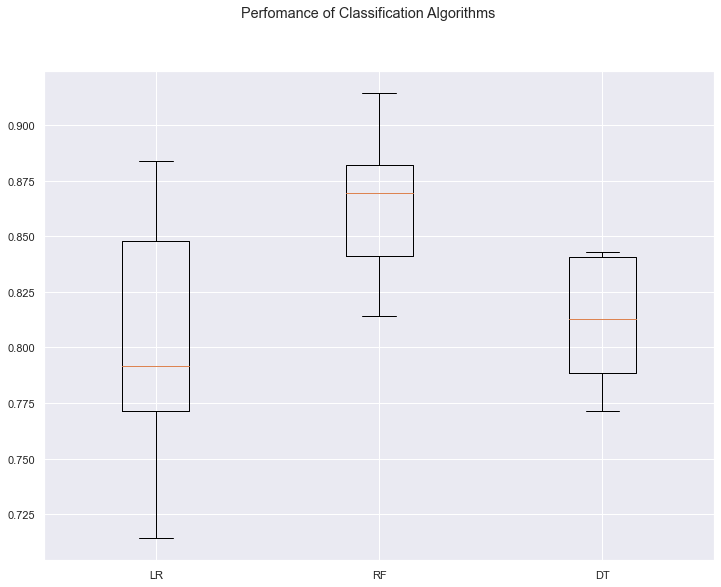

In [87]:
# Perfomance of Classification Algorithms Boxplots
fig = plt.figure()
fig.suptitle('Perfomance of Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results_c)
ax.set_xticklabels(names_c)
plt.show()

In [89]:
# Accuracy, Sensitivity and Specificity scores of all models

# Fit the models
LR = LogisticRegression()
LR.fit(X_train, Y_train)
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)
DT = DecisionTreeClassifier()
DT.fit(X_train, Y_train)

# Make the predictions
predictions_LR = LR.predict(X_test)
predictions_RF = RF.predict(X_test)
predictions_DT = DT.predict(X_test)

# Accuracy Scores
print("Accuracy Scores")
print("LR:", accuracy_score(Y_test, predictions_LR))
print("RF:", accuracy_score(Y_test, predictions_RF))
print("DT:", accuracy_score(Y_test, predictions_DT))
print("")

# Precision Scores
print("Precision Scores")
print("LR:", precision_score(Y_test, predictions_LR))
print("RF:", precision_score(Y_test, predictions_RF))
print("DT:", precision_score(Y_test, predictions_DT))
print("")

# # Specificity Scores
print("Specificity Scores")
tn_LR, fp_LR, fn_LR, tp_LR = confusion_matrix(Y_test, predictions_LR).ravel()
tn_RF, fp_RF, fn_RF, tp_RF = confusion_matrix(Y_test, predictions_RF).ravel()
tn_DT, fp_DT, fn_DT, tp_DT = confusion_matrix(Y_test, predictions_DT).ravel()
print("LR:", tn_LR / (tn_LR+fp_LR))
print("RF:", tn_RF / (tn_RF+fp_RF))
print("DT:", tn_DT / (tn_DT+fp_DT))
print("")

# Sensitivity Scores
print("Recall Scores")
print("LR:", recall_score(Y_test, predictions_LR))
print("RF:", recall_score(Y_test, predictions_RF))
print("DT:", recall_score(Y_test, predictions_DT))
print("")

C:\Users\konto\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy Scores
LR: 0.7885906040268457
RF: 0.8657718120805369
DT: 0.7785234899328859

Precision Scores
LR: 0.8135593220338984
RF: 0.8191489361702128
DT: 0.6545454545454545

Specificity Scores
LR: 0.9444444444444444
RF: 0.9141414141414141
DT: 0.8080808080808081

Recall Scores
LR: 0.48
RF: 0.77
DT: 0.72



### Validation results of the best model

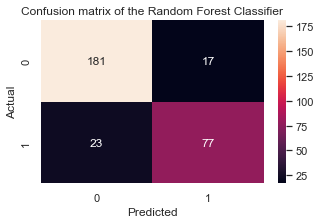

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       198
           1       0.82      0.77      0.79       100

    accuracy                           0.87       298
   macro avg       0.85      0.84      0.85       298
weighted avg       0.86      0.87      0.86       298



In [91]:
# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  
conf_mat = confusion_matrix(Y_test, predictions_RF) #confusion matrix
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix of the Random Forest Classifier')
plt.show()
print(classification_report(Y_test,predictions_RF)) #classification report

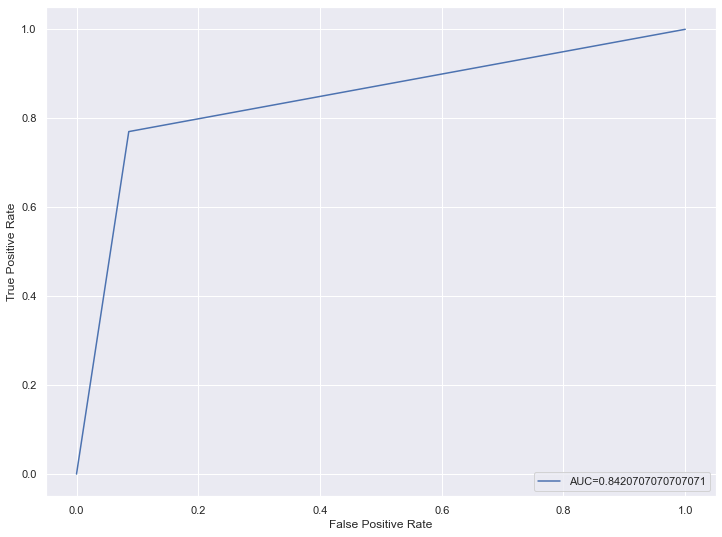

In [92]:
# AUC Curve
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(Y_test,  predictions_RF)
auc = metrics.roc_auc_score(Y_test,  predictions_RF)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

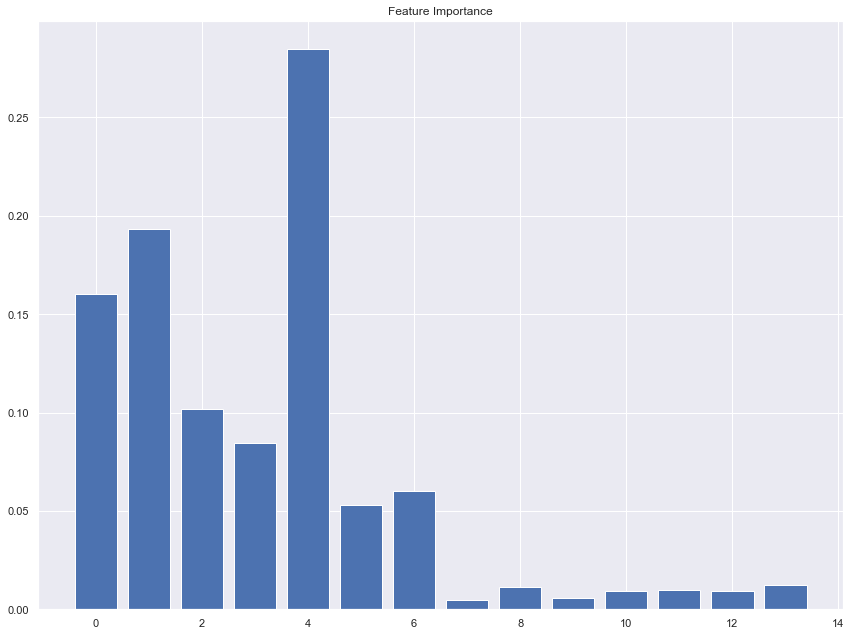

In [93]:
# Variable importance of the best model
importances = RF.feature_importances_

import matplotlib.pyplot as plt
 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances, align='center')
plt.tight_layout()
plt.show()

In [95]:
importances = RF.feature_importances_
importances

array([0.16028882, 0.1934908 , 0.10197589, 0.08432338, 0.28482032,
       0.05298154, 0.06000052, 0.00487499, 0.01109338, 0.00549803,
       0.00949473, 0.00957641, 0.00940944, 0.01217174])